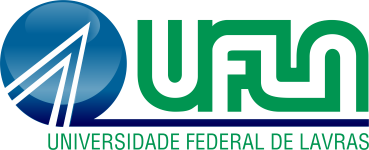

# Parallel Simulated Annealing

Trabalho Final da disciplina **Programação Paralela e Concorrente** (2023/1).


**Professora:** Marluce Rodrigues Pereira

**Alunos:**

- João Gabriel Kondarzewski Zanella - 202020091
- Henrique Curi de Miranda - 202020087
- Victor Gonçalves Lima - 202020775

O trabalho tem como objeto paralelizar o algorimo de otimização ***Simulated Annealing*** e analizar os resutados obtidos.

## Importações

In [1]:
import json
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display

from src.funcoes_registro import carregar_populacao, carregar_solucao_inicial, carregar_parametros_populacao, carregar_cpu_info, carregar_experimentacao, carregar_algoritmos
from src.funcoes_plotagem import plotar_itens

## Dispersão dos itens

In [2]:
parametros_populacao = carregar_parametros_populacao("./parametros_iniciais/")

parametros_populacao

{'numero_itens': 10000,
 'valor_minimo': 1,
 'valor_maximo': 5,
 'tipo_valor': 'int',
 'peso_minimo': 10.0,
 'peso_maximo': 1000.0,
 'tipo_peso': 'float'}

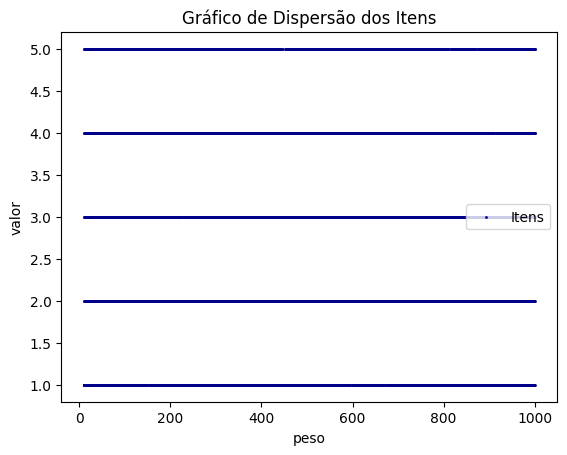

In [3]:
itens = carregar_populacao("./parametros_iniciais/")

plotar_itens(itens)

## Solução aleatória

Total de itens na mochila: 26
Valor total na mochila: 67
Peso total na mochila: 9990.8798892551


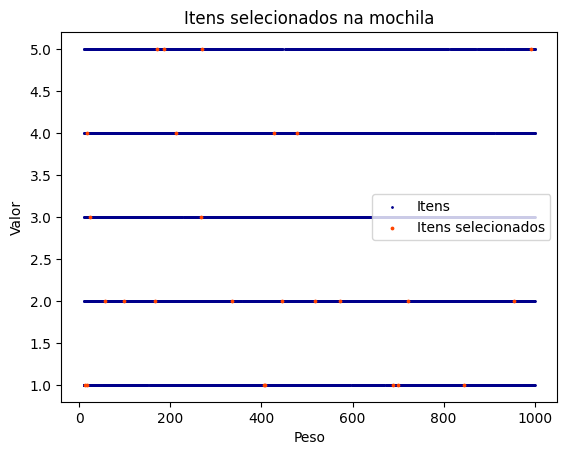

In [4]:
capacidade_das_mochilas = 10000.0 # 10 toneladas
mochila_inicial = carregar_solucao_inicial("./parametros_iniciais/", itens)
plotar_itens(itens, mochila_inicial)

## Funções para prepação dos dados

In [5]:
def carregar_execucoes(parametros_experimentacao, diretorio):
    execucoes = {}
    processes_numbers = parametros_experimentacao["processes_number"]
    numero_execucoes = parametros_experimentacao["numero_execucoes"]
    for i in processes_numbers:
        execucoes[f"psa{i}"] = {"run_times": [],
                                 "final_value": []}
        for j in range(numero_execucoes):
            f = open(f"{diretorio}run-PSA{i}-{j}.json")
            j = json.load(f)
            execucoes[f"psa{i}"]["run_times"].append(j["execution_time"])
            execucoes[f"psa{i}"]["final_value"].append(j["value"][-1])
    return execucoes

## Funções para cálculos estatísticos

## Funções para análises estatísticas

### Desvio padrão

O desvio padrão é definido como:

$$\sigma = \sqrt{\frac{ \sum(x_i - \mu)^2}{N}}$$

onde $N$ é o tamanho da população, $x_i$ é cada valor da população e $\mu$ é a média aritmética da população.

### Intervalo de confiança

O intervalo de confiança pode é definido como:

$$CI = \bar{x} \pm z_{\frac{\alpha}{2}} \frac{\sigma}{\sqrt{n}}$$

onde $\bar{x}$ é a média da amostra, $z_{\frac{\alpha}{2}}$ é o valor crítico para a distribuição normal padrão correspondente a um nível de confiança de $1-\alpha$, $\sigma$ é o desvio padrão da população, e $n$ é o tamanho da amostra.

Para um intervalo de confiança de 95%, será:

$$CI = \bar{x} \pm 1.96 \frac{\sigma}{\sqrt{n}}$$

In [6]:
def media_aritmetica(populacao): 
    return sum(populacao) / len(populacao)

def desvio_padrao(populacao):
    media = media_aritmetica(populacao)
    soma_dos_quadrados = sum((x - media) ** 2 for x in populacao)
    return (soma_dos_quadrados / len(populacao)) ** 0.5

def intervalo_confianca(populacao):
    media = media_aritmetica(populacao)
    desvio = desvio_padrao(populacao)
    margem_de_erro = 1.96 * desvio / (len(populacao) ** 0.5)
    return margem_de_erro

## Funções para exibição dos resultados

In [7]:
def display_execucoes(execucoes):
    display(pd.concat([pd.DataFrame(execucoes[k]) for k in execucoes.keys()],
                      axis=1, keys=execucoes.keys()))
    
def plotar_tempos_execucao(execucoes):
    fig, ax = plt.subplots()
    for key in execucoes:
        ax.plot(execucoes[key]['run_times'], label=key)
    ax.set_xlabel('Execução')
    ax.set_ylabel('Tempo de Execução (segundos)')
    ax.set_ylim(0)
    ax.set_xlim(0, len(execucoes[next(iter(execucoes))]["run_times"]) - 1)
    ax.legend()
    plt.title("Tempo de Execução por Execução")
    plt.show()
    
def plotar_valores_finais(execucoes):
    fig, ax = plt.subplots()
    for key in execucoes:
        ax.plot(execucoes[key]['final_value'], label=key)
    ax.set_xlabel('Execução')
    ax.set_ylabel('Valor final da mochila')
    ax.set_ylim(0)
    ax.set_xlim(0, len(execucoes[next(iter(execucoes))]["run_times"]) - 1)
    ax.legend()
    plt.title("Valor Final da Mochila por Execução")
    plt.show()

def calcular_media_tempo_com_erro(execucoes):
    media = {}
    for k in execucoes.keys():
        ma = media_aritmetica(execucoes[k]["run_times"])
        me = intervalo_confianca(execucoes[k]["run_times"])
        media[k] = (ma, me)
    return media

def display_media_tempos(execucoes):
    threads = [k[3:] for k in execucoes.keys()]
    media = calcular_media_tempo_com_erro(execucoes)
    df = {}
    for k in media.keys():
        df[k] = {"media": media[k][0],
                 "margem_erro": media[k][1]}
    display(pd.DataFrame(df))

def plotar_media_tempos(execucoes):
    threads = [k[3:] for k in execucoes.keys()]
    media = calcular_media_tempo_com_erro(execucoes)
    x, y = [], []
    for k in media.keys():
        x.append(media[k][0])
        y.append(media[k][1])
    fig, ax = plt.subplots()
    plt.plot(threads, x)
    plt.errorbar(threads, x, yerr=y, fmt='none', capsize=10)
    plt.fill_between(threads, [i-k for i, k in zip(x, y)], [i+k for i, k in zip(x, y)], color='b', alpha=.25)
    ax.set_xlabel('Número de threads')
    ax.set_ylabel('Tempo médio de execução (segundos)')
    ax.set_ylim(0)
    ax.set_xlim(0, threads[-1])
    plt.title("Tempo de Execução por Thread (Intervalo de Confiança de 95%)")
    plt.show()
    
def calcular_media_valor_com_erro(execucoes):
    media = {}
    for k in execucoes.keys():
        ma = media_aritmetica(execucoes[k]["final_value"])
        me = intervalo_confianca(execucoes[k]["final_value"])
        media[k] = (ma, me)
    return media

def display_media_valores(execucoes):
    threads = [k[3:] for k in execucoes.keys()]
    media = calcular_media_valor_com_erro(execucoes)
    df = {}
    for k in media.keys():
        df[k] = {"media": media[k][0],
                 "margem_erro": media[k][1]}
    display(pd.DataFrame(df))
    
def plotar_media_valores(execucoes):
    threads = [k[3:] for k in execucoes.keys()]
    media = calcular_media_valor_com_erro(execucoes)
    x, y = [], []
    for k in media.keys():
        x.append(media[k][0])
        y.append(media[k][1])
    fig, ax = plt.subplots()
    plt.plot(threads, x)
    plt.errorbar(threads, x, yerr=y, fmt='none', capsize=10)
    plt.fill_between(threads, [i-k for i, k in zip(x, y)], [i+k for i, k in zip(x, y)], color='b', alpha=.25)
    ax.set_xlabel('Número de threads')
    ax.set_ylabel('Valor Final na Mochila')
    ax.set_ylim(0)
    ax.set_xlim(0, threads[-1])
    plt.title("Valor Final (Intervalo de Confiança de 95%)")
    plt.show()
    
def exibir_resultados_execucoes(execucoes):
    print("Resultados:")
    display_execucoes(execucoes)
    plotar_tempos_execucao(execucoes)
    plotar_valores_finais(execucoes)
    display_media_tempos(execucoes)
    plotar_media_tempos(execucoes)
    display_media_valores(execucoes)
    plotar_media_valores(execucoes)

## Análises

### Análise 1

In [8]:
DIRETORIO_DATA_100 = "./data/notebook_i5_100/"
DIRETORIO_DATA_1000 = "./data/notebook_i5_1000/"
DIRETORIO_DATA_10000 = "./data/notebook_i5_10000/"

In [9]:
cpu_info = carregar_cpu_info(DIRETORIO_DATA_100)
parametros_experimentacao = carregar_experimentacao(DIRETORIO_DATA_100)
parametros_algoritmo = carregar_algoritmos(DIRETORIO_DATA_100)

print("Versão do Python:", cpu_info["python_version"])
print("Hardware da CPU:", cpu_info["brand_raw"])
print("Número de threads disponíveis:", cpu_info["count"])
print()
print("Número de threads utilizadas:", parametros_experimentacao["processes_number"])
print("Número de execuções por thread:", parametros_experimentacao["numero_execucoes"])
print()
print("Parâmetros do algoritmo:")
print("Temperatura inicial:", parametros_algoritmo["temperatura_inicial"])
print("Temperatura final:", parametros_algoritmo["temperatura_final"])
print("Taxa de resfriamento:", parametros_algoritmo["taxa_resfriamento"])

Versão do Python: 3.10.6.final.0 (64 bit)
Hardware da CPU: 11th Gen Intel(R) Core(TM) i5-1135G7 @ 2.40GHz
Número de threads disponíveis: 8

Número de threads utilizadas: [1, 2, 4, 8, 16]
Número de execuções por thread: 10

Parâmetros do algoritmo:
Temperatura inicial: 1
Temperatura final: 0.1
Taxa de resfriamento: 0.01


Número de vizinhos explorados: 100
Resultados:


psa1                  psa2                  psa4                  psa8  \
  run_times final_value run_times final_value run_times final_value run_times   
0  4.044174         706  4.123683         699  4.663251         645  6.321043   
1  4.160810         702  4.089340         678  4.777537         695  6.419170   
2  4.328833         705  4.099600         684  4.687732         665  6.270398   
3  4.266247         711  4.148254         720  4.732279         690  6.248035   
4  4.267458         698  4.125139         725  4.698247         679  6.330266   
5  4.226179         660  4.029595         663  4.849244         719  6.276807   
6  4.275882         702  4.166130         695  4.710735         691  6.283009   
7  4.228222         698  4.057688         713  4.841761         701  6.205854   
8  4.377928         719  4.427462         727  4.677266         675  6.387965   
9  4.254043         692  4.218026         693  4.739103         670  6.219311   

                  psa16              
  final_value run_times final_value  
0         686  9.419147         687  
1         688  9.383012         704  
2         718  9.387505         716  
3         719  9.364698         685  
4         677  9.274371         701  
5         738  9.517527         716  
6         696  9.517398         738  
7         682  9.303747         692  
8         668  9.397130         671  
9         692  9.269533         666

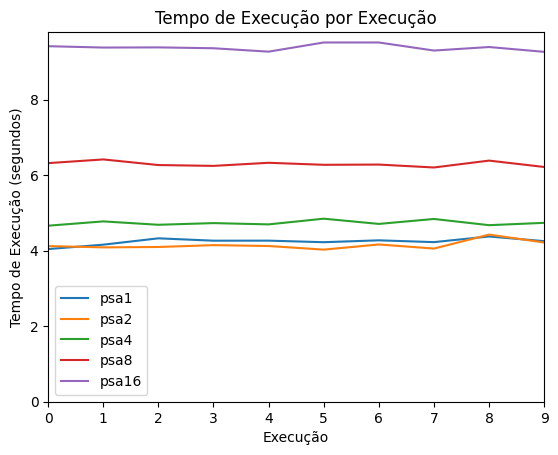

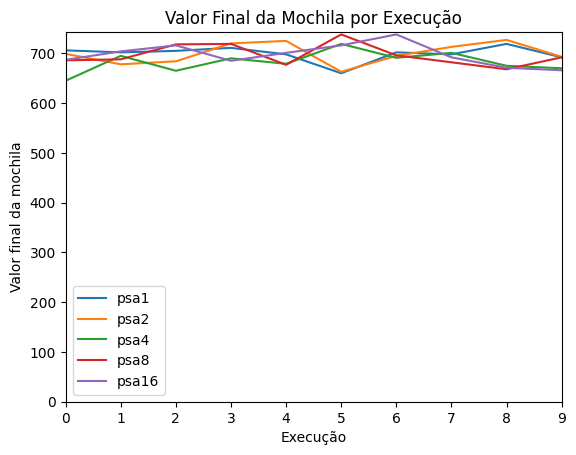

,psa1,psa2,psa4,psa8,psa16
media,4.242977,4.148492,4.737716,6.296186,9.383407
margem_erro,0.053570,0.065712,0.038640,0.040610,0.051476


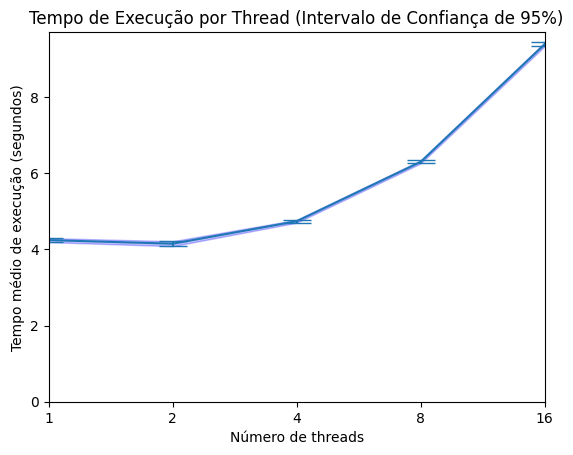

,psa1,psa2,psa4,psa8,psa16
media,699.300000,699.700000,683.000000,696.400000,697.600000
margem_erro,9.230955,12.559456,12.230777,12.847198,12.957364


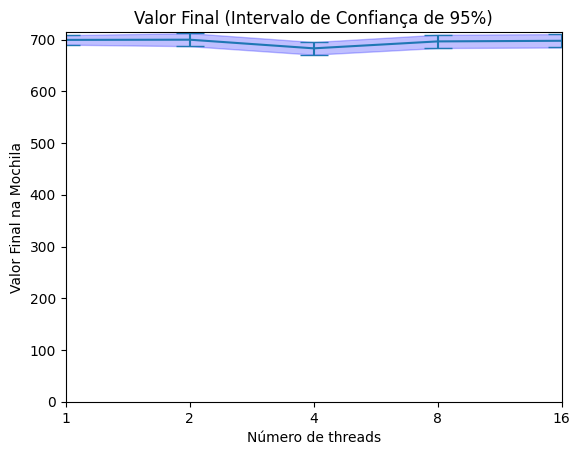

In [10]:
parametros_algoritmo = carregar_algoritmos(DIRETORIO_DATA_100)
parametros_experimentacao = carregar_experimentacao(DIRETORIO_DATA_100)
execucoes_100 = carregar_execucoes(parametros_experimentacao,
                                   DIRETORIO_DATA_100)

print("Número de vizinhos explorados:", parametros_algoritmo["numero_vizinhos_explorar"])
exibir_resultados_execucoes(execucoes_100)

Número de vizinhos explorados: 1000
Resultados:


psa1                   psa2                   psa4              \
   run_times final_value  run_times final_value  run_times final_value   
0  12.493814         804  10.673468         811  10.088367         814   
1  12.936853         830  10.429383         780  10.239532         818   
2  13.443513         809  10.878269         791   9.896110         817   
3  13.133958         821  10.946875         807  10.137882         834   
4  12.745322         807  10.914615         813  10.576617         831   
5  12.459068         780  10.795789         841  11.183124         808   
6  13.267338         784  10.316021         800  10.867780         807   
7  13.194921         813  10.870808         789  10.695814         789   
8  13.006050         815  10.537940         815  10.782006         797   
9  12.794346         816  10.681816         826  10.921947         799   

        psa8                  psa16              
   run_times final_value  run_times final_value  
0  11.491532         822  14.217463         827  
1  11.393401         811  14.163681         811  
2  11.248737         822  14.177085         826  
3  12.145509         861  14.430472         799  
4  11.319938         770  14.403483         805  
5  11.469903         816  14.376079         809  
6  11.036633         795  14.181836         819  
7  11.375494         832  14.302223         814  
8  11.509297         799  14.141219         829  
9  11.336603         796  14.808195         826

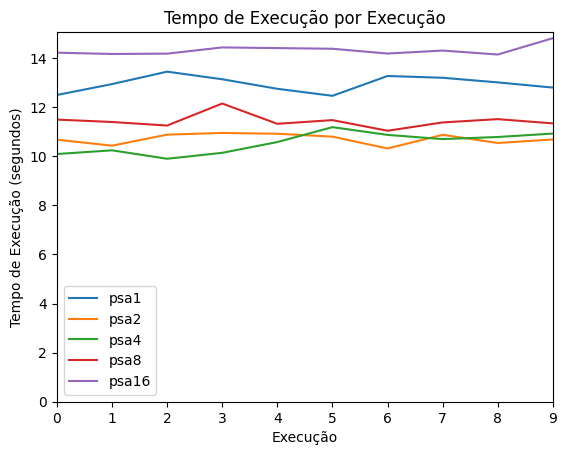

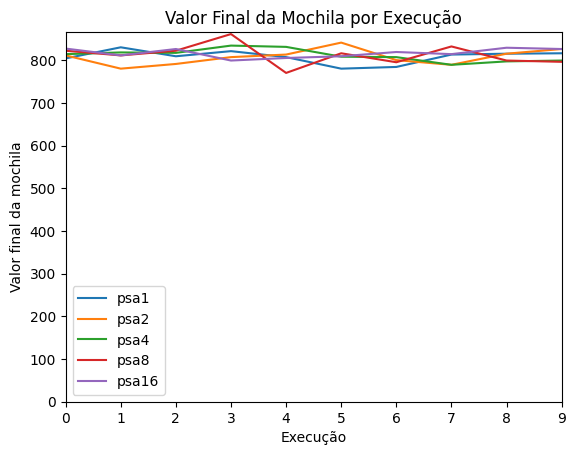

,psa1,psa2,psa4,psa8,psa16
media,12.947518,10.704498,10.538918,11.432705,14.320173
margem_erro,0.191697,0.127762,0.249594,0.168182,0.118802


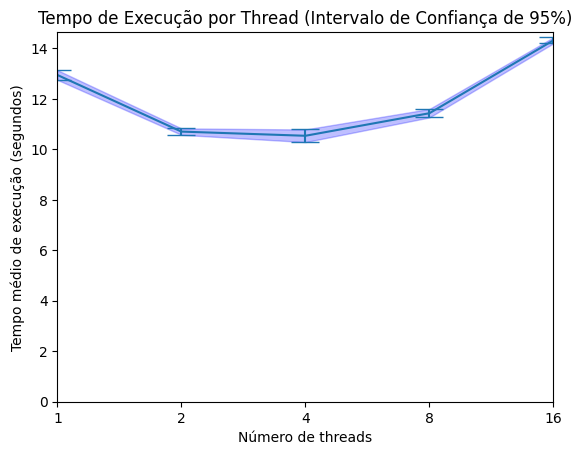

,psa1,psa2,psa4,psa8,psa16
media,807.900000,807.300000,811.400000,812.400000,816.500000
margem_erro,9.128004,10.717634,8.476632,14.528347,6.149842


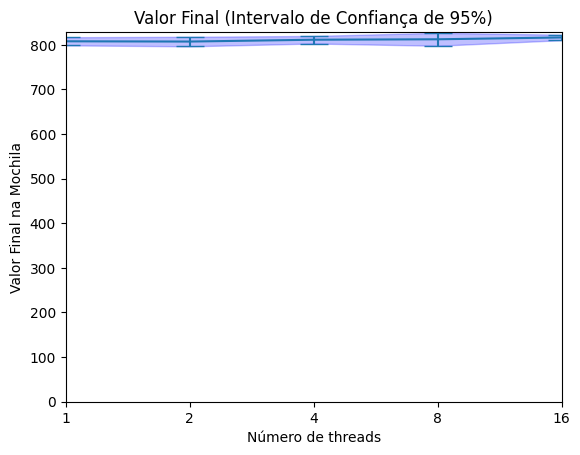

In [11]:
parametros_algoritmo = carregar_algoritmos(DIRETORIO_DATA_1000)
parametros_experimentacao = carregar_experimentacao(DIRETORIO_DATA_1000)
execucoes_1000 = carregar_execucoes(parametros_experimentacao,
                                   DIRETORIO_DATA_1000)

print("Número de vizinhos explorados:", parametros_algoritmo["numero_vizinhos_explorar"])
exibir_resultados_execucoes(execucoes_1000)

Número de vizinhos explorados: 10000
Resultados:


psa1                   psa2                   psa4              \
   run_times final_value  run_times final_value  run_times final_value   
0  89.842020         849  62.531554         813  52.374615         835   
1  87.799839         819  61.899371         826  56.436920         830   
2  88.348284         814  63.258492         823  57.035374         805   
3  93.778350         851  63.368140         836  55.443668         807   
4  88.749961         829  63.748317         841  56.442944         819   
5  88.568960         838  63.901951         833  57.440311         829   
6  91.663724         819  61.211401         803  55.941169         790   
7  91.780770         824  61.079640         827  54.329635         792   
8  88.999232         830  64.612360         831  58.190017         839   
9  90.678249         838  62.885899         834  57.597467         805   

        psa8                  psa16              
   run_times final_value  run_times final_value  
0  55.243442         825  58.292257         807  
1  55.277216         814  59.806901         831  
2  52.824226         809  60.025853         833  
3  54.655568         826  58.958426         837  
4  55.788429         826  62.685494         841  
5  57.283972         838  60.551329         853  
6  56.482282         826  58.316003         796  
7  55.556995         837  59.806237         822  
8  55.808549         829  60.405610         838  
9  56.394614         812  60.672826         823

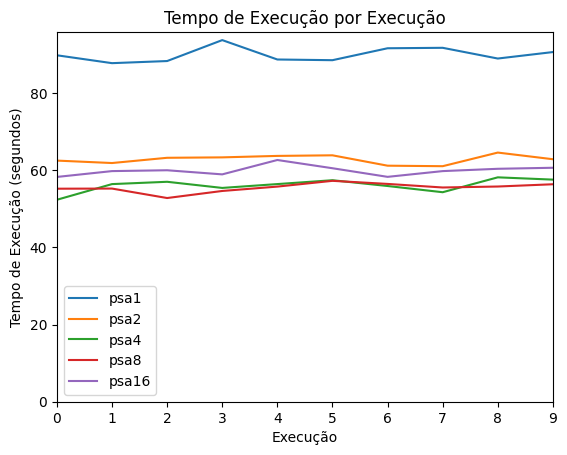

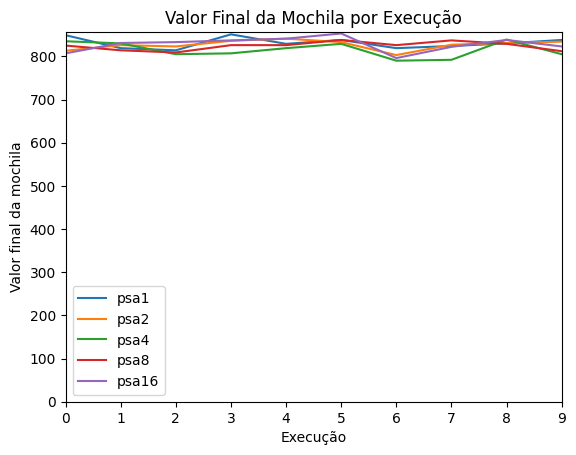

,psa1,psa2,psa4,psa8,psa16
media,90.020939,62.849712,56.123212,55.531529,59.952094
margem_erro,1.123826,0.686850,1.018000,0.709611,0.759679


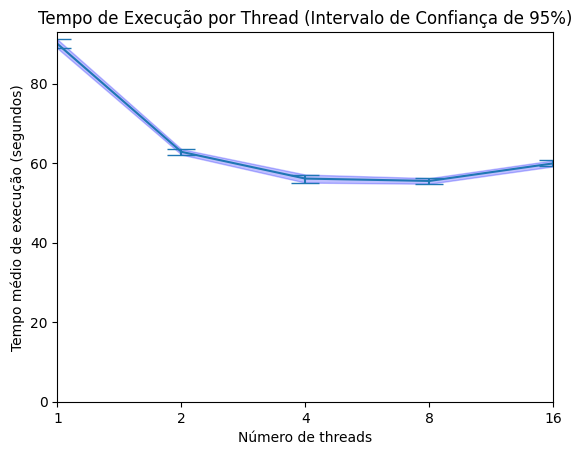

,psa1,psa2,psa4,psa8,psa16
media,831.100000,826.700000,815.100000,824.200000,828.100000
margem_erro,7.470917,6.693048,10.428416,5.786483,9.868167


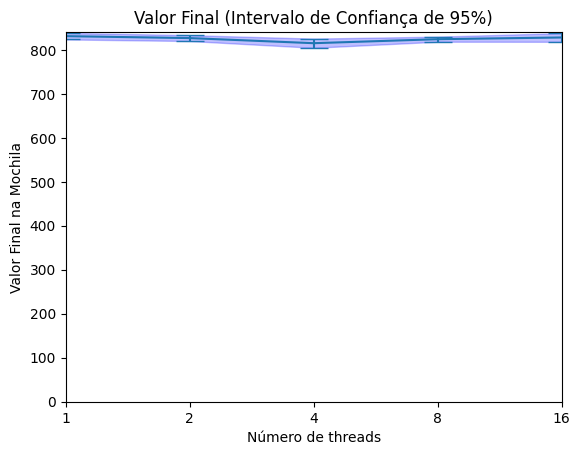

In [12]:
parametros_algoritmo = carregar_algoritmos(DIRETORIO_DATA_10000)
parametros_experimentacao = carregar_experimentacao(DIRETORIO_DATA_10000)
execucoes_10000 = carregar_execucoes(parametros_experimentacao,
                                   DIRETORIO_DATA_10000)

print("Número de vizinhos explorados:", parametros_algoritmo["numero_vizinhos_explorar"])
exibir_resultados_execucoes(execucoes_10000)

### Análise 2

In [13]:
DIRETORIO_DATA_100 = "./data/ryzen_5700x_100/"
DIRETORIO_DATA_1000 = "./data/ryzen_5700x_1000/"
DIRETORIO_DATA_10000 = "./data/ryzen_5700x_10000/"

In [14]:
cpu_info = carregar_cpu_info(DIRETORIO_DATA_100)
parametros_experimentacao = carregar_experimentacao(DIRETORIO_DATA_100)
parametros_algoritmo = carregar_algoritmos(DIRETORIO_DATA_100)

print("Versão do Python:", cpu_info["python_version"])
print("Hardware da CPU:", cpu_info["brand_raw"])
print("Número de threads disponíveis:", cpu_info["count"])
print()
print("Número de threads utilizadas:", parametros_experimentacao["processes_number"])
print("Número de execuções por thread:", parametros_experimentacao["numero_execucoes"])
print()
print("Parâmetros do algoritmo:")
print("Temperatura inicial:", parametros_algoritmo["temperatura_inicial"])
print("Temperatura final:", parametros_algoritmo["temperatura_final"])
print("Taxa de resfriamento:", parametros_algoritmo["taxa_resfriamento"])

Versão do Python: 3.11.4.final.0 (64 bit)
Hardware da CPU: AMD Ryzen 7 5700X 8-Core Processor
Número de threads disponíveis: 16

Número de threads utilizadas: [1, 2, 4, 8, 16]
Número de execuções por thread: 10

Parâmetros do algoritmo:
Temperatura inicial: 1
Temperatura final: 0.1
Taxa de resfriamento: 0.01


Número de vizinhos explorados: 100
Resultados:


psa1                  psa2                  psa4                  psa8  \
  run_times final_value run_times final_value run_times final_value run_times   
0  3.377119         674  2.916713         698  2.815569         707  3.720597   
1  3.636874         730  2.943799         681  2.828198         698  3.486356   
2  3.213272         708  2.981807         675  2.909361         712  3.481564   
3  3.499331         674  2.988331         701  2.808823         713  3.470438   
4  3.491576         699  3.011410         688  2.956923         679  3.400033   
5  3.647639         694  2.960358         696  2.855173         714  3.453624   
6  3.568515         717  3.005594         703  2.794527         680  3.479386   
7  3.890748         674  2.898794         701  2.854408         697  3.371237   
8  3.816052         735  2.898004         701  2.796229         693  3.393283   
9  3.579224         683  2.958816         675  2.984295         720  3.348856   

                  psa16              
  final_value run_times final_value  
0         720  4.984910         713  
1         685  4.817562         699  
2         706  4.944695         708  
3         720  4.935077         690  
4         687  5.054036         684  
5         660  5.061325         675  
6         754  4.865820         670  
7         707  5.019924         682  
8         699  4.794214         644  
9         720  4.995577         739

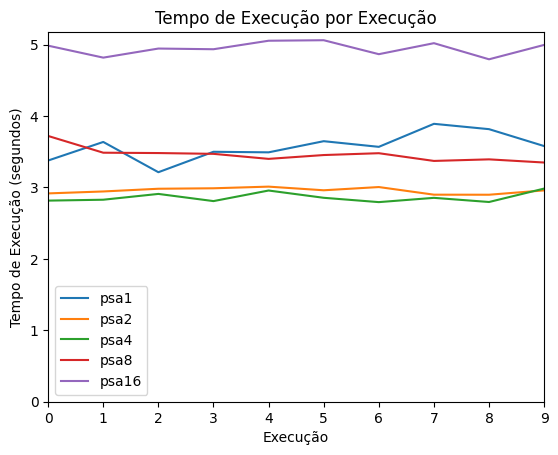

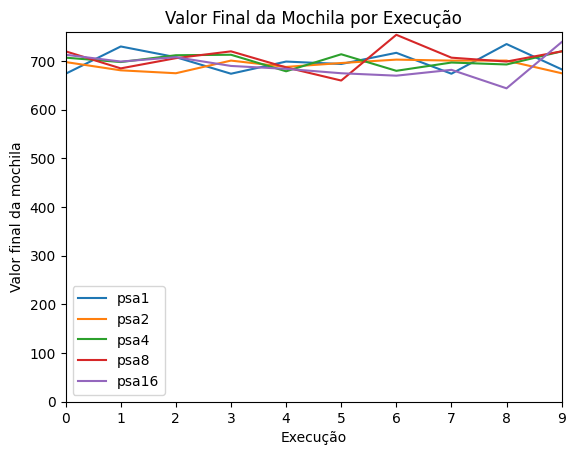

,psa1,psa2,psa4,psa8,psa16
media,3.572035,2.956362,2.860351,3.460537,4.947314
margem_erro,0.115884,0.024476,0.039828,0.061318,0.055602


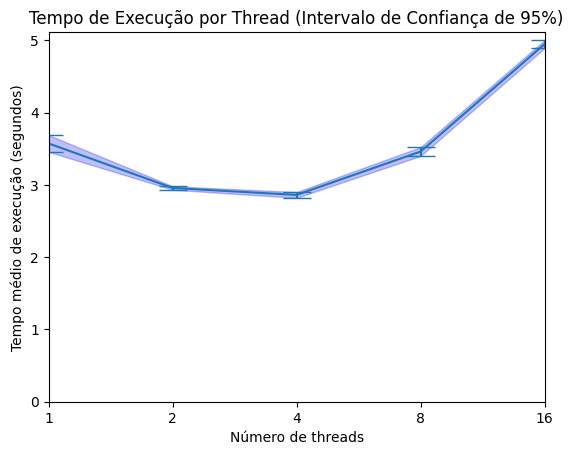

,psa1,psa2,psa4,psa8,psa16
media,698.800000,691.900000,701.300000,705.800000,690.400000
margem_erro,13.604151,6.591256,8.416825,15.003413,15.401161


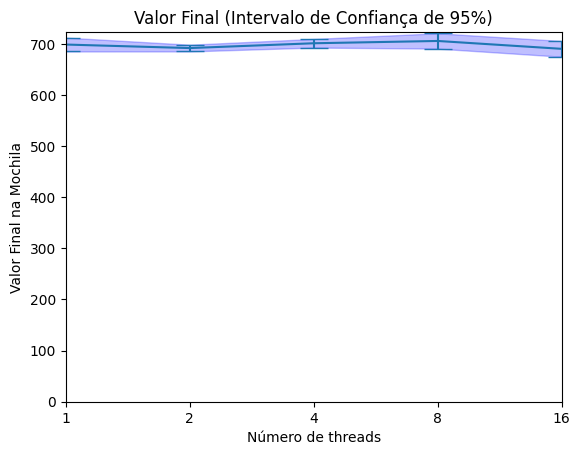

In [15]:
parametros_algoritmo = carregar_algoritmos(DIRETORIO_DATA_100)
parametros_experimentacao = carregar_experimentacao(DIRETORIO_DATA_100)
execucoes_100 = carregar_execucoes(parametros_experimentacao,
                                   DIRETORIO_DATA_100)

print("Número de vizinhos explorados:", parametros_algoritmo["numero_vizinhos_explorar"])
exibir_resultados_execucoes(execucoes_100)

Número de vizinhos explorados: 1000
Resultados:


psa1                   psa2                  psa4              \
   run_times final_value  run_times final_value run_times final_value   
0  18.640604         832  13.628633         804  8.900467         827   
1  17.383549         810  13.422289         813  8.874274         817   
2  17.737154         824  13.287993         797  8.984806         782   
3  18.183904         817  13.328565         816  8.419574         797   
4  17.727541         788  12.867227         816  8.800434         811   
5  16.798083         765  13.295212         813  8.789181         831   
6  17.821372         825  12.686439         793  8.770530         820   
7  18.409101         813  12.705658         814  9.095911         820   
8  18.149312         819  12.401629         775  8.618222         821   
9  17.556416         788  13.230063         818  8.548685         806   

       psa8                 psa16              
  run_times final_value run_times final_value  
0  8.262481         808  9.106219         821  
1  8.081675         800  9.109487         797  
2  8.619782         819  9.112080         803  
3  8.918737         806  9.205979         822  
4  8.148837         823  9.011142         810  
5  8.035530         798  9.407464         836  
6  8.519442         842  9.232386         836  
7  8.265495         797  8.626722         791  
8  8.091159         817  9.582042         843  
9  8.355323         795  9.375628         813

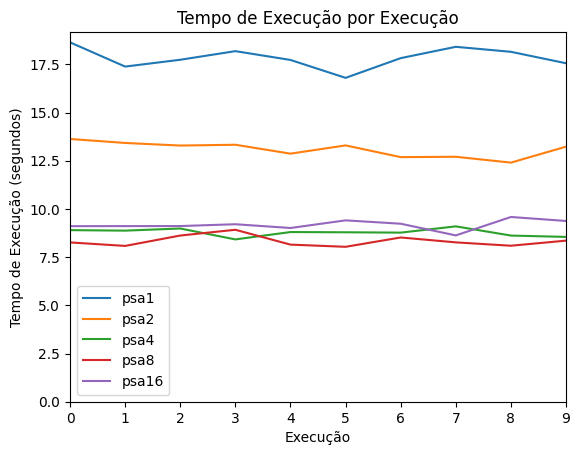

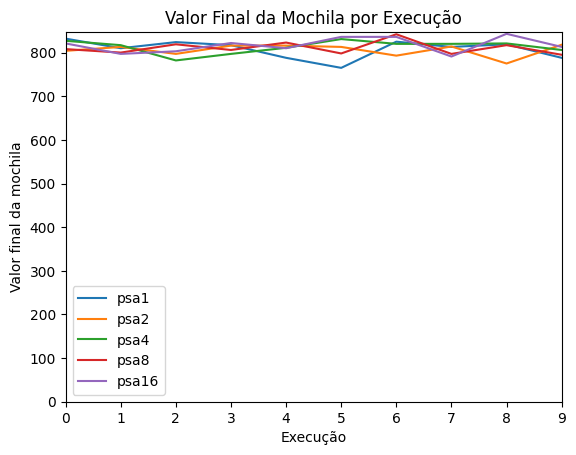

,psa1,psa2,psa4,psa8,psa16
media,17.840704,13.085371,8.780209,8.329846,9.176915
margem_erro,0.314622,0.231266,0.120076,0.165626,0.152406


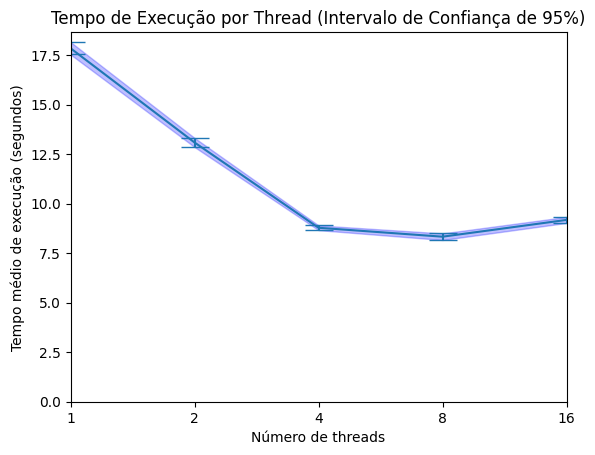

,psa1,psa2,psa4,psa8,psa16
media,808.100000,805.900000,813.200000,810.500000,817.200000
margem_erro,12.397523,8.130811,8.694097,8.718145,10.326057


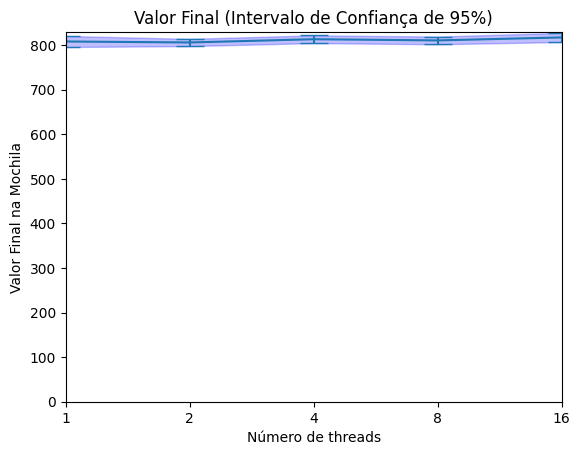

In [16]:
parametros_algoritmo = carregar_algoritmos(DIRETORIO_DATA_1000)
parametros_experimentacao = carregar_experimentacao(DIRETORIO_DATA_1000)
execucoes_1000 = carregar_execucoes(parametros_experimentacao,
                                   DIRETORIO_DATA_1000)

print("Número de vizinhos explorados:", parametros_algoritmo["numero_vizinhos_explorar"])
exibir_resultados_execucoes(execucoes_1000)

Número de vizinhos explorados: 10000
Resultados:


psa1                   psa2                   psa4              \
    run_times final_value  run_times final_value  run_times final_value   
0  128.695035         835  92.937787         817  61.956626         805   
1  130.633848         819  93.018335         819  59.115875         809   
2  140.074393         830  88.140422         814  66.259886         825   
3  131.801532         843  93.595978         855  66.475625         848   
4  131.526087         832  88.548665         814  62.393033         813   
5  132.660532         825  87.630016         810  61.059376         805   
6  137.451535         830  82.854427         805  62.280399         823   
7  137.494935         834  88.998339         820  65.243204         827   
8  134.725586         847  93.943719         836  67.958490         841   
9  127.901269         810  86.716671         809  63.271286         832   

        psa8                  psa16              
   run_times final_value  run_times final_value  
0  54.708189         834  48.193346         823  
1  58.664449         823  49.453996         864  
2  58.207021         850  50.889464         823  
3  58.917671         841  47.179428         838  
4  54.604862         838  47.625782         824  
5  55.719451         846  46.158837         823  
6  55.646602         823  51.126899         834  
7  56.006588         823  45.272464         842  
8  53.381320         810  51.154264         834  
9  56.912380         840  46.942984         815

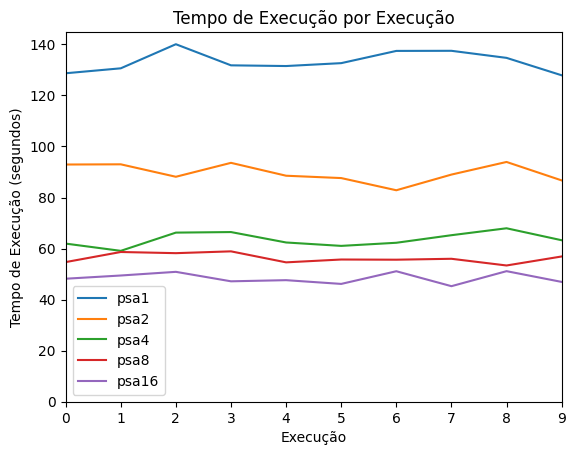

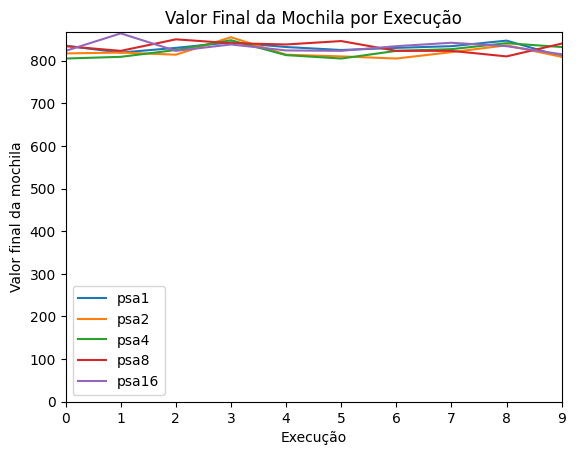

,psa1,psa2,psa4,psa8,psa16
media,133.296475,89.638436,63.601380,56.276853,48.399746
margem_erro,2.368429,2.137583,1.635276,1.095240,1.260958


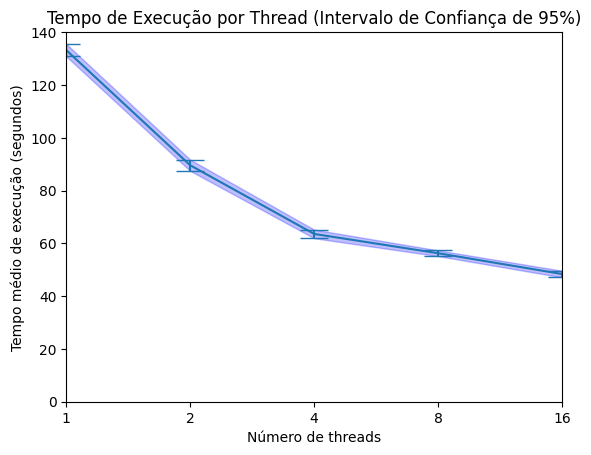

,psa1,psa2,psa4,psa8,psa16
media,830.500000,819.900000,822.800000,832.800000,832.000
margem_erro,6.340532,8.784868,8.751351,7.400395,8.232


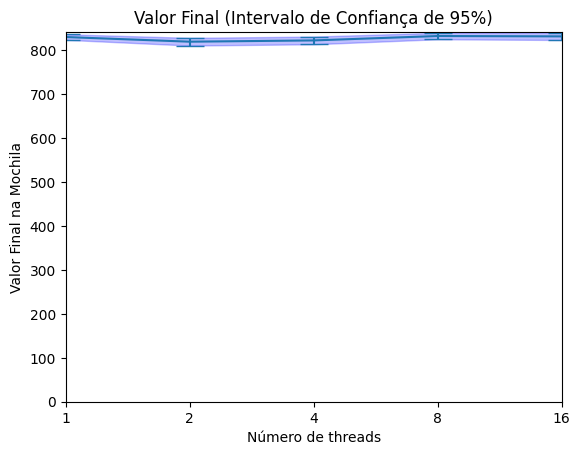

In [17]:
parametros_algoritmo = carregar_algoritmos(DIRETORIO_DATA_10000)
parametros_experimentacao = carregar_experimentacao(DIRETORIO_DATA_10000)
execucoes_10000 = carregar_execucoes(parametros_experimentacao,
                                     DIRETORIO_DATA_10000)

print("Número de vizinhos explorados:", parametros_algoritmo["numero_vizinhos_explorar"])
exibir_resultados_execucoes(execucoes_10000)